# Laboratorio 11 C - Forecasting con RNN.

Este laboratorio demuestra cómo hacer predicciones o forecasting en series de tiempo usando una RNN. Se trabajará con el dataset [Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate), el cual tiene informacion climatica de la ciudad de Jena, Alemania dentro del periodo 2009 - 2016.

Dada una secuencia de valores de variables climaticas, se entrena un modelo para predecir el valor de la temperatura en el step siguiente (proxima hora).

Se pueden generar estimaciones sucesivas de temperatura realimentando al modelo con las predicciones a medida que se van generando (autorregresivo).

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [3]:
import os

REPO_NAME = "lab11"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/FCEIA-AAII/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'lab11'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 588 (delta 1), reused 8 (delta 0), pack-reused 578
Receiving objects: 100% (588/588), 263.86 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (578/578), done.


Importar librerías

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

Establecer GPU por defecto en caso de estar disponible.

In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preparacion del dataset

In [6]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 2s 0us/step


In [7]:
df = pd.read_csv(csv_path)

df = df[5::6] # cambiar granularidad de 10 min a 1 hora por registro

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


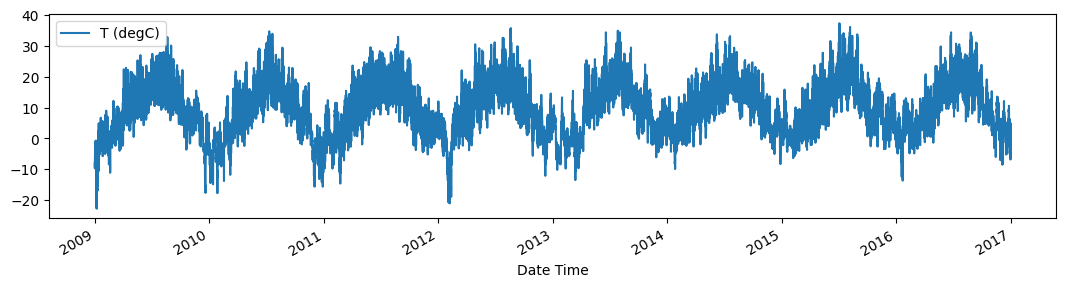

In [8]:
# Visualizar temperatura (target)
plot_features = df[['T (degC)']]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(13, 3))

In [9]:
# Revisar rangos y estadisticos por variable
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [10]:
# Reemplazar minimo en velocidad del viento
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# Convertir velocidad y direccion del viento a vector
# Esto es para que sea mas interpretable para el modelo
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

# Convertir tiempo a senoidal para destacar estacionalidad
# Igual que en el viento es para que al modelo le resulte mas interpretable
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [11]:
# Dividir data en train, test y validacion (teniendo en cuenta la temporalidad de los datos)
column_indices = {name: i for i, name in enumerate(df.columns)}

train_df = df[:df.shape[0] * 70 // 100]
val_df = df[df.shape[0] * 70 // 100:-df.shape[0] * 10 // 100]
test_df = df[-df.shape[0] * 10 // 100:]

num_features = df.shape[1]

# Normalizar la info
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3, test_example=False):
    if test_example:
      inputs, labels = next(iter(self.test))
    else:
      inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        if test_example:
          plt.scatter(self.label_indices, predictions[n, label_col_index],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
        else:
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


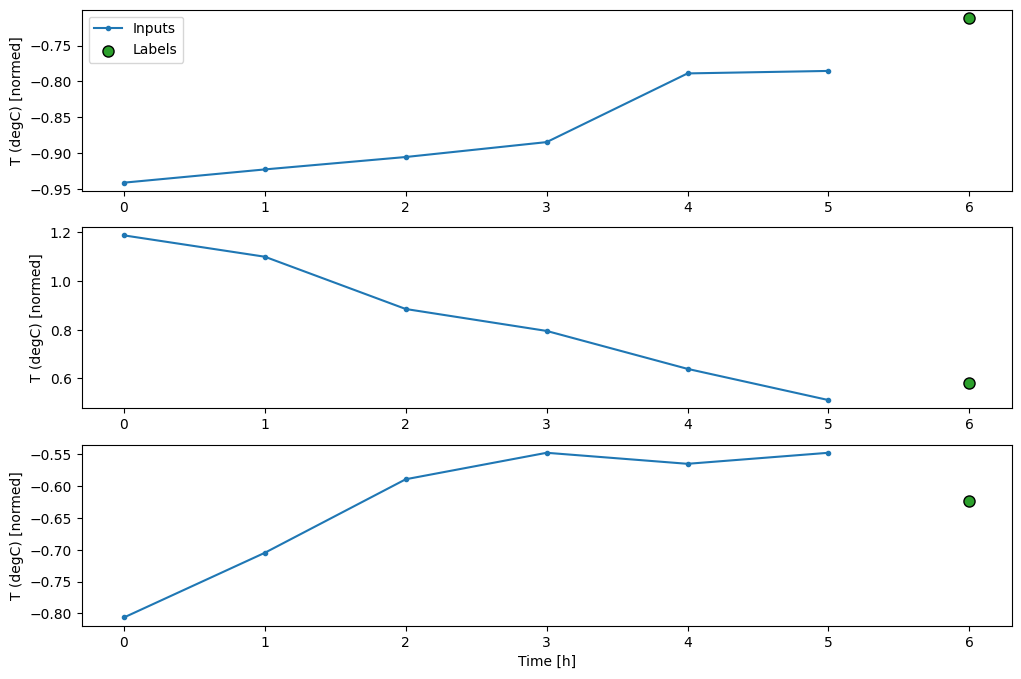

In [13]:
# Generar ventanas para la RNN
window = WindowGenerator(input_width=6, label_width=1, shift=1,label_columns=['T (degC)'])

print(window)

# Ver ejemplos de las ventanas generadas
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('\nAll shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

window.plot()

In [14]:
# Ver info de cada item en el dataset de entrenamiento
print(window.train.element_spec)

# Ver un ejemplo (el metodo make_dataset de WindowGenerator tiene un batch default de 32, por eso la primera dimension tiene ese valor)
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Modelo

In [15]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, window)

Epoch 1/20
1534/1534 [==============================] - 23s 9ms/step - loss: 0.0228 - mean_absolute_error: 0.0940 - val_loss: 0.0074 - val_mean_absolute_error: 0.0629
Epoch 2/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0064 - val_mean_absolute_error: 0.0573
Epoch 3/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0064 - mean_absolute_error: 0.0564 - val_loss: 0.0060 - val_mean_absolute_error: 0.0546
Epoch 4/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0554 - val_loss: 0.0060 - val_mean_absolute_error: 0.0542
Epoch 5/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0551 - val_loss: 0.0061 - val_mean_absolute_error: 0.0550


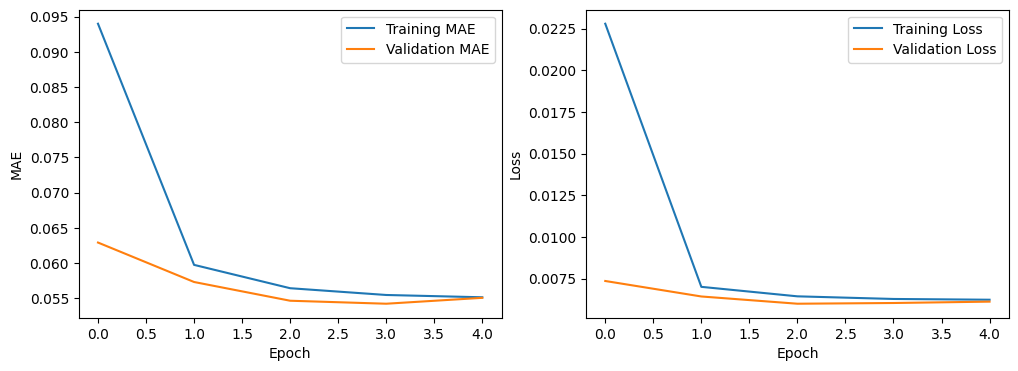

In [17]:
# Visualización del MAE y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# metricas de test
test_performance = lstm_model.evaluate(window.test, verbose=0, return_dict=True)

test_performance

{'loss': 0.006153473164886236, 'mean_absolute_error': 0.056070536375045776}

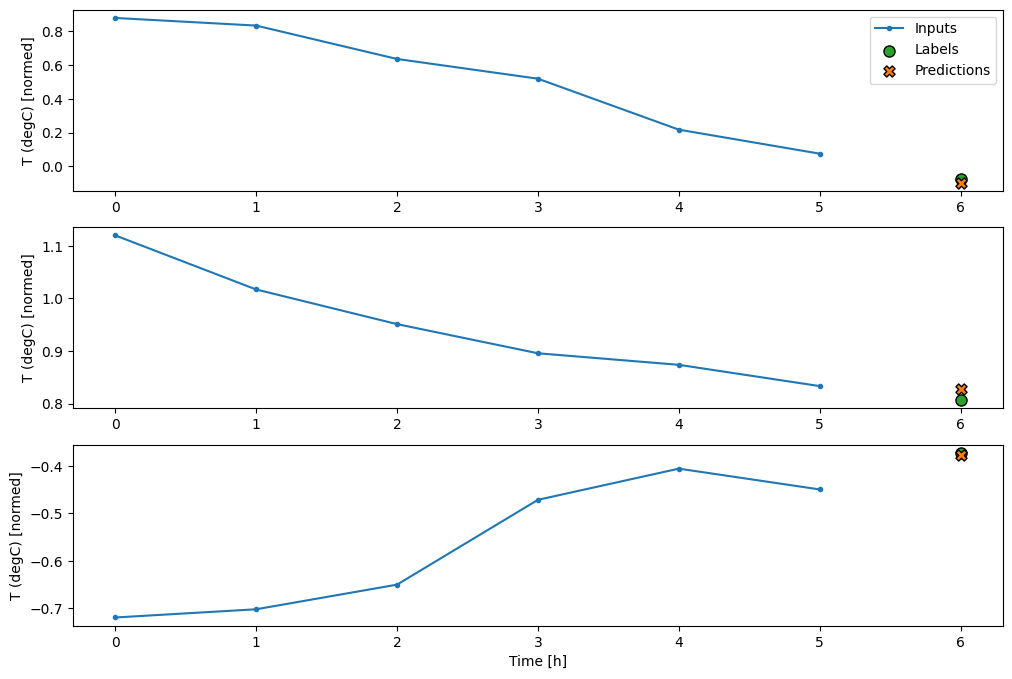

In [19]:
# Algunos ejemplos usando el dataset de test
window.plot(model=lstm_model, test_example=True)

# Autorregresivo

En el apartado anterior el modelo predice el proximo step en funcion de `n` anteriores, ahora vamos a predecir multiples time step en vez de uno solo.

Esto se puede hacer de dos maneras, como vimos en teoria: predecir `n` valores todos juntos (single shot) o ir generando cada estimacion y retroalimentar al modelo con el valor para estimar las siguientes (autoregresive, lo que vemos aca)

In [20]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17]
Label column name(s): None

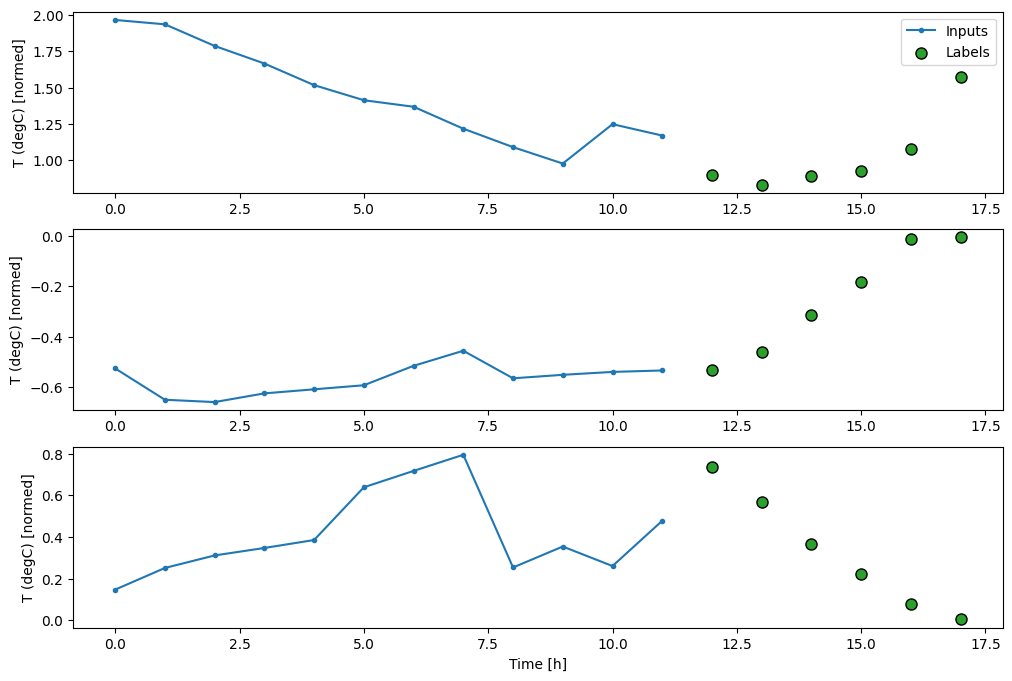

In [21]:
OUT_STEPS = 6
ar_window = WindowGenerator(input_width=12,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

ar_window.plot()
ar_window

In [23]:
ar_model = FeedBack(units=32, out_steps=OUT_STEPS)

ar_history = compile_and_fit(ar_model, ar_window)

test_performance = ar_model.evaluate(ar_window.test, verbose=0, return_dict=True)

Epoch 1/20
1533/1533 [==============================] - 55s 33ms/step - loss: 0.2004 - mean_absolute_error: 0.2914 - val_loss: 0.1406 - val_mean_absolute_error: 0.2334
Epoch 2/20
1533/1533 [==============================] - 35s 23ms/step - loss: 0.1333 - mean_absolute_error: 0.2217 - val_loss: 0.1294 - val_mean_absolute_error: 0.2158
Epoch 3/20
1533/1533 [==============================] - 35s 23ms/step - loss: 0.1266 - mean_absolute_error: 0.2110 - val_loss: 0.1248 - val_mean_absolute_error: 0.2073
Epoch 4/20
1533/1533 [==============================] - 37s 24ms/step - loss: 0.1231 - mean_absolute_error: 0.2053 - val_loss: 0.1234 - val_mean_absolute_error: 0.2046
Epoch 5/20
1533/1533 [==============================] - 36s 23ms/step - loss: 0.1206 - mean_absolute_error: 0.2015 - val_loss: 0.1212 - val_mean_absolute_error: 0.2011
Epoch 6/20
1533/1533 [==============================] - 38s 25ms/step - loss: 0.1189 - mean_absolute_error: 0.1990 - val_loss: 0.1203 - val_mean_absolute_error:

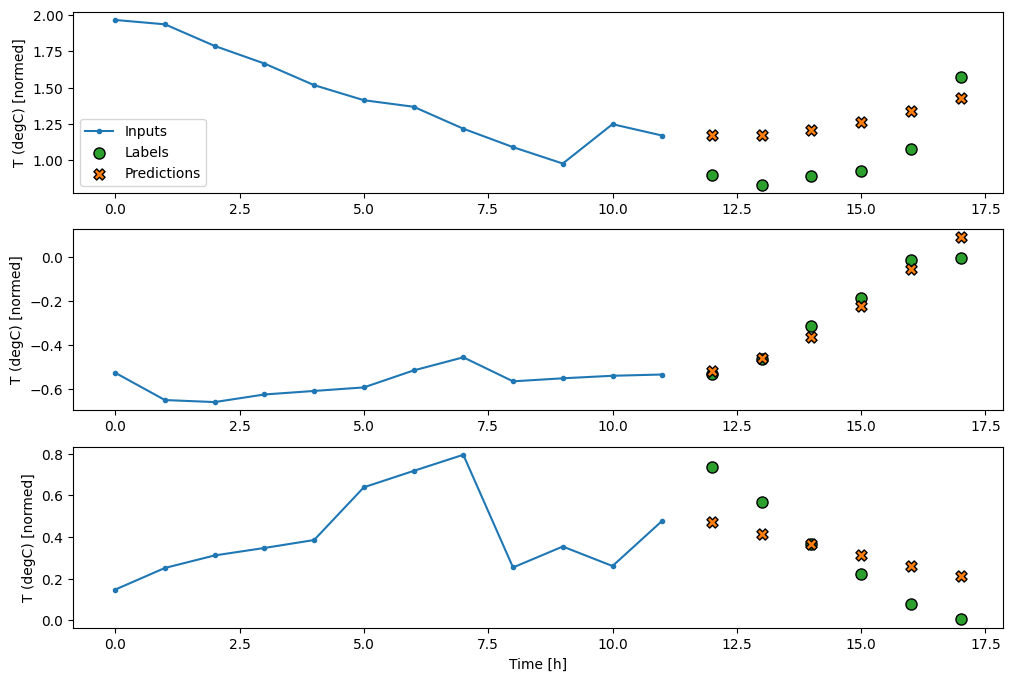

In [30]:
ar_window.plot(ar_model)

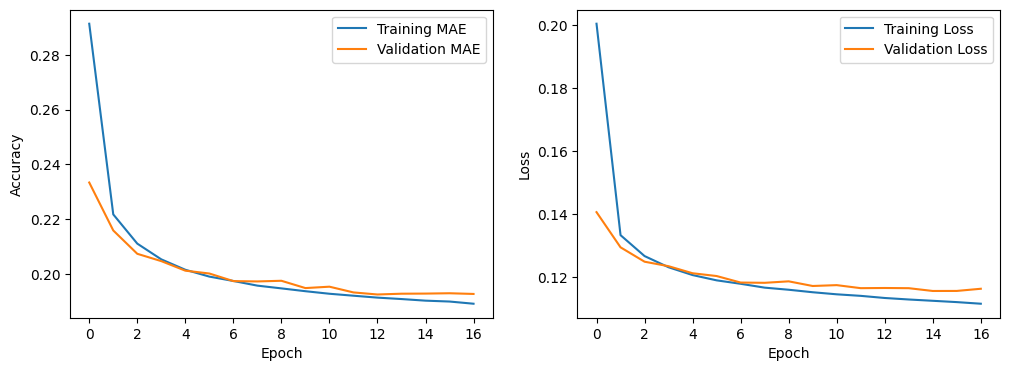

In [31]:
# Visualización del MAE y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ar_history.history['mean_absolute_error'], label='Training MAE')
plt.plot(ar_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(ar_history.history['loss'], label='Training Loss')
plt.plot(ar_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()